# Statistics
## CCS 1 - Week 5

In this notebook, we outline how to conduct some common statistical analyses in Python. 

As outlined in the lecture, it's always good to combine visulalizations with statistical analysis and not just blindly calculate some statistics without understanding the data. Therefore, for consistency, we'll use the same datasets we used in the visualization examples.

In [1]:
import pandas as pd

import seaborn as sns               # for the dataset

from scipy.stats import pearsonr    # for bivariate correlations
from scipy.stats import contingency # for crosstab statistics
import pingouin as pg               # for t-tests
import numpy as np                  # always handy but now needed for t-tests
from statsmodels.formula.api import ols  # for regression

/home/damian/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/damian/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 1. Univariate statistics

In [3]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
titanic['class'].value_counts()

Third     491
First     216
Second    184
Name: class, dtype: int64

In [5]:
# You want percentages instead? No problem, just set normalize=True:
titanic['class'].value_counts(normalize=True)

Third     0.551066
First     0.242424
Second    0.206510
Name: class, dtype: float64

# 2. Bivariate statistics

## 2.1 Continous variables

In [6]:
# Let us first create a temporary dataset without missings on the variables we care about
# That's because we cannot calculate a correlation if we have missings.

df = titanic[['fare','age']].dropna()
print(f"We deleted {len(titanic)-len(df)} of the originally {len(titanic)} rows.")
print(f"We created a new dataset df with only the columns fare and age and no missing values.")

We deleted 177 of the originally 891 rows.
We created a new dataset df with only the columns fare and age and no missing values.


In [7]:
# The test itself is just one line - it returns a tuple with the correlation and its p-value)
pearsonr(df['fare'], df['age'])

(0.0960666917690389, 0.010216277504442105)

In [8]:
# or nicely formatted with an f-string:
r, p = pearsonr(df['fare'], df['age'])
print(f"The correlation between the variables age and fare is r={r:.3f}, p={p:.3f}.")

The correlation between the variables age and fare is r=0.096, p=0.010.


## 2.2 Nominal variables

In [9]:
#let's look at the crosstab
mycrosstab = pd.crosstab(titanic['sex'], titanic['class'])
mycrosstab


class,First,Second,Third
sex,,,
female,94,76,144
male,122,108,347


In [10]:
# and then get the chi2 test for that table
c, p, dof, expected = contingency.chi2_contingency(mycrosstab)
print(f"𝜒²({dof:.0f}) = {c:.3f}, p = {p:.3f} ")

# maybe Cramer's V as well?
print(f"V = {contingency.association(mycrosstab,method='cramer'):.3f}")

𝜒²(2) = 16.971, p = 0.000 
V = 0.138


# 3. Hypothesis testing and group comparisons

## 3.1 Two groups: t-test
T-tests can be a simple way to compare the means of two groups with each other. It's actually not that popular to do t-tests in pandas, I guess because they
- are mathematically equivalent to a regression with a dummy variable for the group and therefore not really needed
- very often, one may want to control for other things anyway

In any event, there is no convenient way to do a t-test out of the box on a pandas dataframe that would conform to the reporting guidelines you learned in your statitics classes, therefore I wrote a function that does so.
You do **not** have to change the function, you can just copy-paste it if needed. Then, you can just use the function with one line.

In [11]:
# Damian's function to provide a simple way to display the results of a t-test
# Note: pg.ttest() automatically checks for equality of variances (see pg.ttest? )
# so you don't have to do this manually. Take that, SPSS!!!

def pandasttest(df, dv, between):
    '''Takes a dataframe, the name of the column that indicates the group (`between`), 
    and the name of the column that contains the dependent variable (`dv`) as
    input and then prints a t-test'''
    
    assert len(df[between].unique())==2, "There are more than two groups, aborting"
             
    (label1, values1), (label2, values2) = df.groupby(between)[dv]
    testresult = pg.ttest(values1, values2)
    display(testresult)
    print(f"The difference between group {label1} (M={np.mean(values1):.2f}, SD={np.std(values1):.3f}) "
         f"and group {label2} (M={np.mean(values2):.2f}, SD={np.std(values2):.3f}) "
         f"is {'not ' if not (testresult['p-val']<.05).iloc[0] else''}significant, "
         f"t({testresult.iloc[0,1]})={testresult.iloc[0,0]:.3f}, "
         f"p={testresult.iloc[0,3]:.4f}.")



In [12]:
# As you see, with the functions below
pandasttest(titanic, dv = 'fare', between = 'survived')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.839099,436.702276,two-sided,2.699332e-11,"[-33.83, -18.73]",0.54691,4.378e+08,1.0


The difference between group 0 (M=22.12, SD=31.360) and group 1 (M=48.40, SD=66.500) is significant, t(436.7022760386057)=-6.839, p=0.0000.


## 3.2 More groups: ANOVA

This is simple:

In [13]:
aov = pg.anova(data=titanic, dv='fare', between='class', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,class,7.760301e+05,2,388015.028289,242.344157,1.031376e-84,0.353094
1,Within,1.421769e+06,888,1601.090919,NaN,NaN,NaN


In [14]:
# post-hoc test
titanic.pairwise_tukey(dv='fare', between='class').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Third,First,13.676,84.155,-70.479,3.267,-21.573,0.000,-1.760
1,Third,Second,13.676,20.662,-6.987,3.459,-2.020,0.108,-0.174
2,First,Second,84.155,20.662,63.493,4.014,15.817,0.000,1.584


### 3.2.1 ANOVA with interaction

In [15]:
titanic.anova(dv="fare", between=["class", "sex"],effsize="n2").round(3)

,Source,SS,DF,MS,F,p-unc,n2
0,class,734712.224,2.0,367356.112,242.621,0.0,0.341
1,sex,31748.565,1.0,31748.565,20.968,0.0,0.015
2,class * sex,50028.158,2.0,25014.079,16.521,0.0,0.023
3,Residual,1339992.013,885.0,1514.115,NaN,NaN,NaN


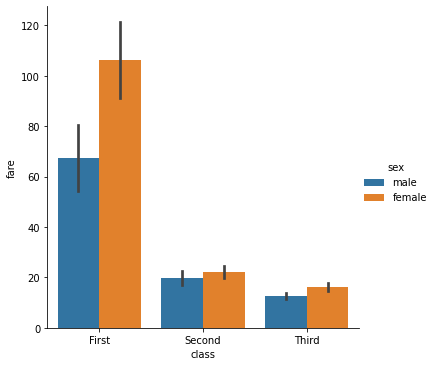

In [16]:
# Let's visualize this:
sns.catplot(x='class', y='fare', hue='sex', kind='bar', data=titanic)

### 3.2.1 ANCOVA
We can also add one or more covariates:

In [17]:
pg.ancova(data=titanic, dv='fare', covar=['age'], between='class',effsize="n2")

,Source,SS,DF,F,p-unc,n2
0,class,7.370039e+05,2,210.782291,1.382121e-72,0.36628
1,age,3.386363e+04,1,19.369920,1.242410e-05,0.01683
2,Residual,1.241264e+06,710,NaN,NaN,NaN


# 4. Regression
Estimating a regression model is easy, we just need to specify the formula as follows:
`dependent_variable ~ indepent_variable_1 + independent_variable_2 + independent_variable_x ....`

In [18]:
ols("fare ~ age + sex", data=titanic).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     17.60
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           3.46e-08
Time:                        21:02:21   Log-Likelihood:                -3829.1
No. Observations:                 714   AIC:                             7664.
Df Residuals:                     711   BIC:                             7678.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      35.9578      4.923      7.304      0.000      26.293      45.623
sex[T.male]   -21.4845      4.037     -5.321      0.000     -29.411     -13.558
age             0.4164      0.134      3.109      0.002       0.153       0.679
==============================================================================
Omnibus:                      729.973   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35014.528
Skew:                           4.748   Prob(JB):                         0.00
Kurtosis:                      35.966   Cond. No.                         93.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.1 Mediation Analysis
It's acually astonishlingly easy to test a mediation model in Python. Note that here, it doesn't make much sense theoretically (and you shouldn't do this with a binary dependent variable), but this is how it looks like if we estimate the model  `age --> fare --> survival`:

In [19]:
pg.mediation_analysis(data=titanic, x='age', m='fare', y='survived', seed=42, n_boot=1000)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,fare ~ X,0.349964,0.135893,1.021628e-02,0.083165,0.616762,Yes
1,Y ~ fare,0.002491,0.000335,3.155995e-13,0.001832,0.003149,Yes
2,Total,-0.002613,0.001264,3.912465e-02,-0.005094,-0.000131,Yes
3,Direct,-0.003517,0.001221,4.091448e-03,-0.005914,-0.001120,Yes
4,Indirect,0.000904,0.000313,0.000000e+00,0.000318,0.001503,Yes
